Today, i want to discuss about another interesting CNN architecture, called - GoogLeNet.

### New ideas

As always, every paper brings to us something new, rather it new method or optimization of old. GoogLeNet was designed by the team of Google (which is not surprising) and have some interesting ideas of implementation.

The main goal of reserchers was not the high accuracy, but efficiency. Google wanted to have such netwotk that can be executed even in weak devices. So, how actually this was implemented?

1. From dense connection to sparse

Traditional CNNs use **dense connections**, where every input channel is processed by a single fixed kernel (like 5x5 or 3x3) to create output channels. This is computationally expensive and inefficient because it assumes all features exist at the same scale. Furthermore, a single large kernel forces the hardware to calculate many connections that might have near-zero importance.

Theory suggests that the most efficient neural networks are **sparse**, meaning neurons only connect to others with which they are highly correlated (the Hebbian principle: "neurons that fire together, wire together"). However, modern GPUs are optimized for **dense matrix math**; random sparse connections cause "cache misses" and lookups that make them 100x slower in practice.

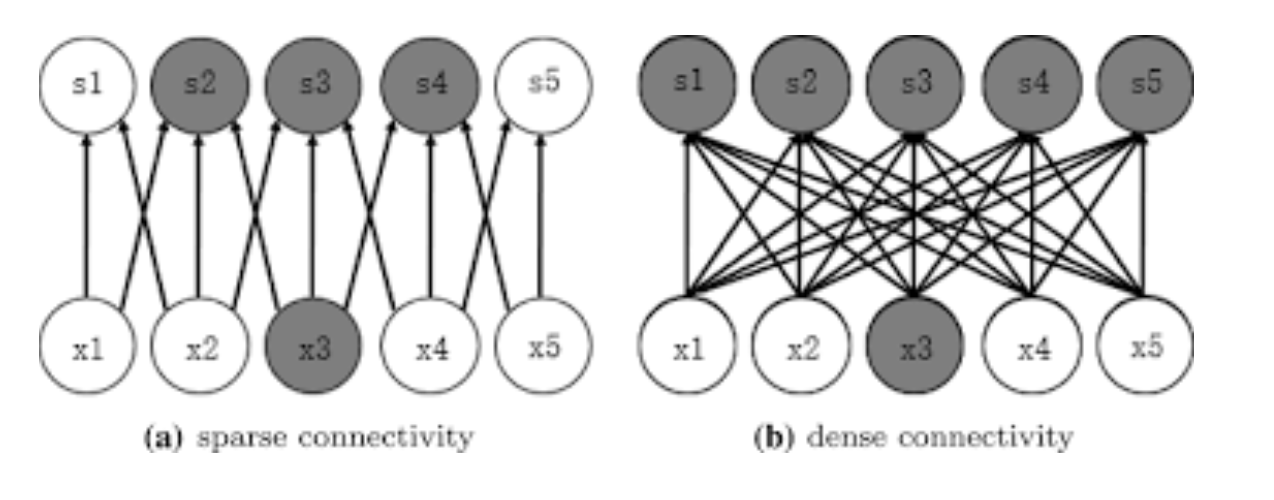

GoogLeNet bridges this gap using the **Inception Module**. Instead of one giant dense layer, it splits the operation into four parallel, specialized branches (1x1, 3x3, 5x5, and pooling).
* **Multi-Scale Detection**: It handles objects of different sizes (like a cat appearing close or far) by looking through multiple "lenses" simultaneously.
* **Logical Sparsity**: By channeling information into specific filter sizes, it mimics a sparse structure where not everything is connected to everything.
* **Computational Density**: Because each individual branch is a dense matrix, the GPU can still run them at maximum speed.

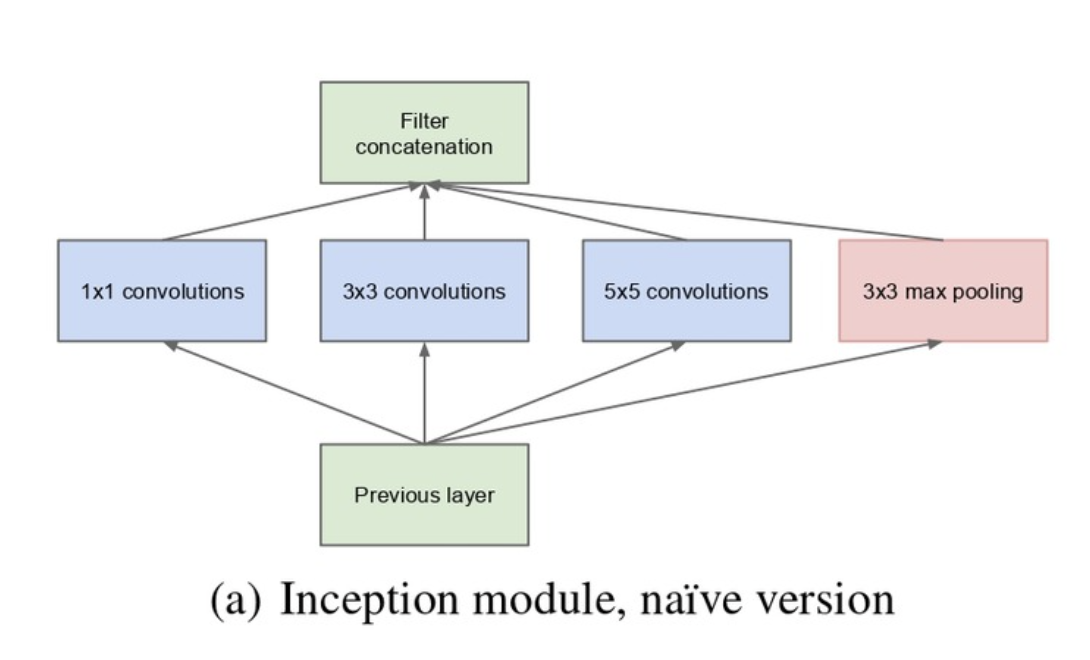

2. Dimensionality reduction

While this approach is a great idea, it has some cons: computing for example 5x5 convolution will be very expensive, but here reseachers also came up with some cool idea - use of 1x1 convolution. As we know from "Network in network" paper, 1x1 convolution can be a useful tool. But here the purpose of it differs - it is used for dimensionality reduction before 3x3, 5x5 filtering in order to decrease computational cost.

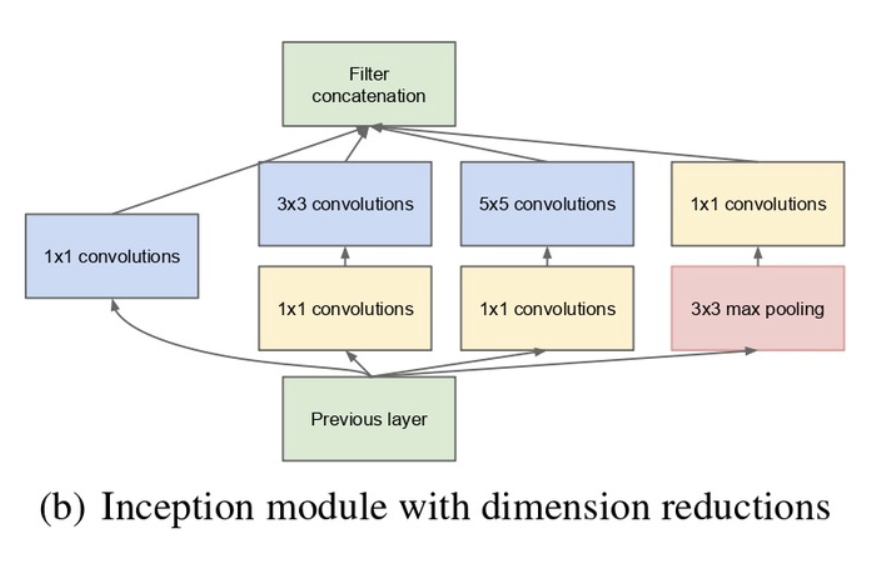

### Architecture

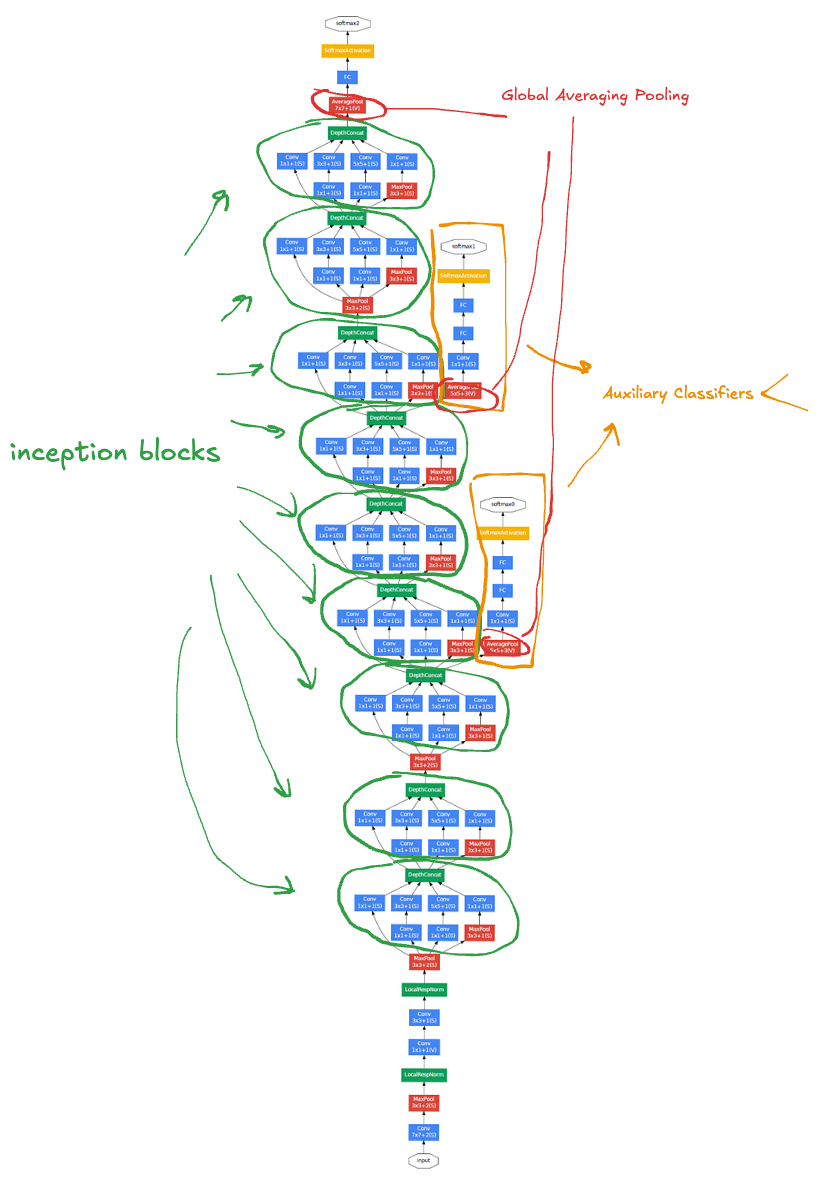

As networks grow deeper, they face the **Vanishing Gradient Problem**. From the image above, we see that GoogLeNet is 22 layers deep, the team at Google was concerned that the gradient signal would become too weak as it traveled back from the final layer to the first, causing learning to stall.

The researchers introduced **Auxiliary Classifiers**—mini-networks attached to the middle of the main architecture (specifically after modules **4a** and **4d**).
* **Gradient Boost**: These branches compute their own loss, injecting a "fresh" gradient signal directly into the middle layers to ensure they continue to learn.
* **Feature Discrimination**: By forcing intermediate layers to perform classification, the model is encouraged to develop highly useful, "discriminative" features much earlier in the network.
* **Regularization**: These extra tasks provide a form of regularization, helping the model generalize better to new data.

Implementation Details:
* **Weighted Loss**: During training, the losses from these auxiliary branches are multiplied by a **0.3 weight** (a "discount") before being added to the total loss.
* **Training Only**: Once the model is trained, these auxiliary networks are **discarded**. They do not add any extra computational cost during actual use (inference).

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../..")) 

from utils.utils import min_max_scaling, \
    set_random_seeds, plot_images, get_top_k_confident_mistakes, compute_FLOPS, compare_architectures, \
    plot_top_mistakes, plot_training_results, plot_filters_and_feature_maps, count_params, get_gpu
from models.AlexNet import AlexNet
from models.VGG import VGG, get_vgg_features
from models.NiN import NiN, NiN_without_AGP
from engine.DatasetProvider import DatasetProvider, DatasetName
from engine.Trainer import Trainer
from models.AlexNet import AlexNet
from models.GoogLeNet import GoogLeNet
import torchvision
from torchvision.transforms import transforms
import torch.nn.functional as F
import torch
from torch import nn
import torch.utils.data as data
from torchinfo import summary
import copy
import numpy as np
import matplotlib.pyplot as plt

In [3]:
googlenet = GoogLeNet(in_channels=3, out_features=10)

googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (net): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BasicConv2d(
    (net): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv3): BasicConv2d(
    (net): Sequential(
      (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (inception3a)

In [4]:
batch_size = 256
summary(googlenet, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
GoogLeNet                                     [256, 10]                 4,350,484
├─BasicConv2d: 1-1                            [256, 64, 112, 112]       --
│    └─Sequential: 2-1                        [256, 64, 112, 112]       --
│    │    └─Conv2d: 3-1                       [256, 64, 112, 112]       9,408
│    │    └─BatchNorm2d: 3-2                  [256, 64, 112, 112]       128
│    │    └─ReLU: 3-3                         [256, 64, 112, 112]       --
├─MaxPool2d: 1-2                              [256, 64, 55, 55]         --
├─BasicConv2d: 1-3                            [256, 64, 55, 55]         --
│    └─Sequential: 2-2                        [256, 64, 55, 55]         --
│    │    └─Conv2d: 3-4                       [256, 64, 55, 55]         4,096
│    │    └─BatchNorm2d: 3-5                  [256, 64, 55, 55]         128
│    │    └─ReLU: 3-6                         [256, 64, 55, 55]         --
├─Bas

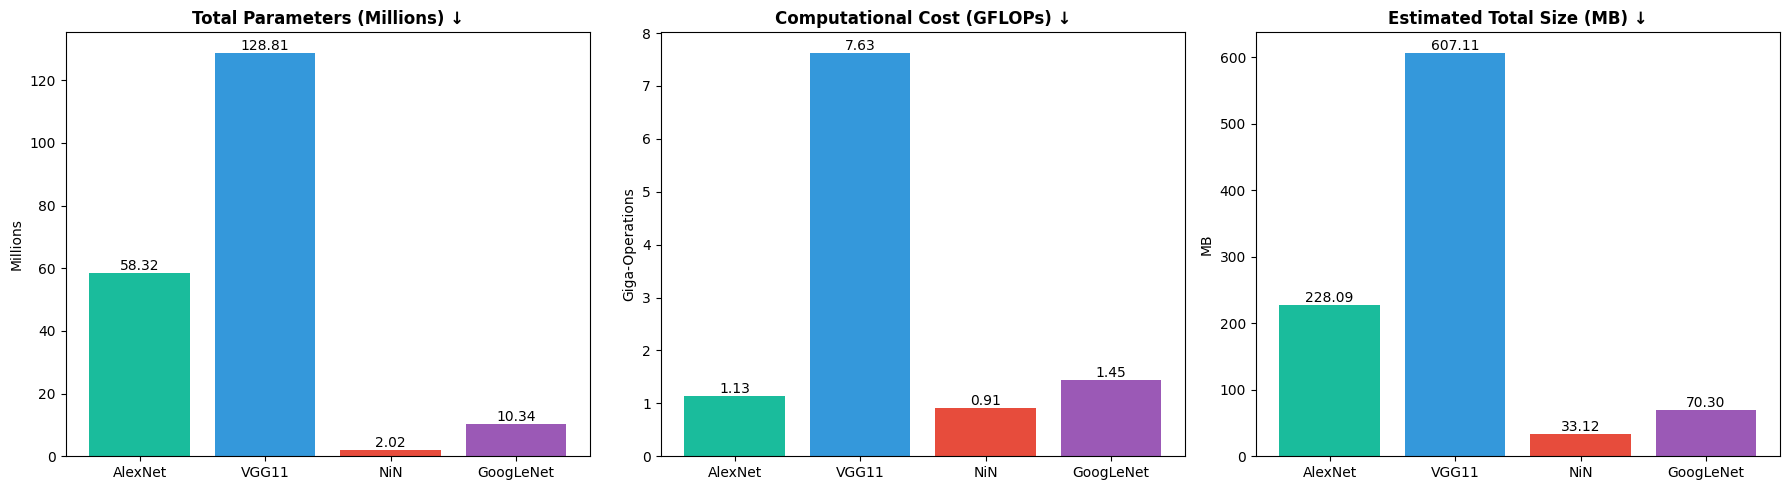

In [6]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

models_to_compare = {
    "AlexNet": AlexNet(3, 10),
    "VGG11": VGG(3, 10, config=vgg11_config),
    "NiN": NiN(3, 10),
    "GoogLeNet": googlenet
}

compare_architectures(models_to_compare, input_size=(1, 3, 227, 227))

The original GoogLeNet architecture has approximately 6.8 million parameters, but since auxiliary classifiers abd BatchNorm used here - this increases the number of params during training.